# Azure AI Inference Tracing - Hello World Example
## 1. Env Setup
First, set up your environment variables and install packages:

In [ ]:
!pip install azure-ai-inference[opentelemetry]
!pip install opentelemetry 
!pip install opentelemetry-exporter-otlp
!pip install open-telemetry-sdk
!pip install azure-monitor-opentelemetry 

## 2. Setup Environment Variables and Tracing

In [11]:
import os
from opentelemetry import trace
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor, ConsoleSpanExporter
from azure.core.settings import settings
from opentelemetry.trace import get_tracer
from azure.monitor.opentelemetry import configure_azure_monitor
from azure.ai.inference.tracing import AIInferenceInstrumentor
import os
from opentelemetry import trace
from opentelemetry.trace import get_tracer
from azure.monitor.opentelemetry import configure_azure_monitor
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential

# visit https://github.com/Azure/azure-sdk-for-python/blob/main/sdk/ai/azure-ai-inference/README.md#key-concepts
os.environ["AZURE_AI_CHAT_ENDPOINT"] = "https://fsunavala-oai-aueast.openai.azure.com/openai/deployments/gpt-4o-mini"
os.environ["AZURE_AI_CHAT_KEY"] = "YOUR-AOAI-KEY"
os.environ["APPLICATIONINSIGHTS_CONNECTION_STRING"] = "YOUR-INSTRUMENTATION-KEY"
os.environ["AZURE_TRACING_GEN_AI_CONTENT_RECORDING_ENABLED"] = "true"  # For detailed traces

# Additional variables if using Azure Monitor (optional)
os.environ["AZURE_SUBSCRIPTION_ID"] = "YOUR-SUBSCRIPTION-ID"  # Optional for portal viewing
os.environ["AZURE_RESOURCE_GROUP"] = "YOUR-RESOURCE-GROUP"    # Optional for portal viewing
os.environ["AZURE_WORKSPACE_NAME"] = "YOUR-AZURE-WORKSPACE-PROJECT"    # Optional for portal viewing

# Configure Azure Monitor
configure_azure_monitor()

# Get tracer
tracer = get_tracer(__name__)

import os
from azure.ai.inference.tracing import AIInferenceInstrumentor
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Enable detailed tracing
os.environ['AZURE_TRACING_GEN_AI_CONTENT_RECORDING_ENABLED'] = 'true'

# Attempt to instrument AI Inference
try:
    AIInferenceInstrumentor().instrument()
    logger.info("AI Inference Instrumentation enabled successfully.")
except RuntimeError as e:
    if "Already instrumented" in str(e):
        logger.warning("AI Inference Instrumentation is already enabled.")
    else:
        logger.error(f"Failed to enable AI Inference Instrumentation: {str(e)}")
        raise


## 3. Simple Chat Function

In [12]:
@tracer.start_as_current_span("hello_world_chat")
def hello_world_chat():
    try:
        # Create client
        client = ChatCompletionsClient(
            endpoint=os.environ["AZURE_AI_CHAT_ENDPOINT"],
            credential=AzureKeyCredential(os.environ["AZURE_AI_CHAT_KEY"])
        )
        
        # Add span attributes
        span = trace.get_current_span()
        span.set_attribute("operation", "chat_completion")
        
        # Simple chat
        messages = [
            SystemMessage(content="You are a helpful assistant."),
            UserMessage(content="Say hello!")
        ]
        
        # Get response
        response = client.complete(messages=messages)
        print(f"Assistant: {response.choices[0].message.content}")
        
    except Exception as e:
        span = trace.get_current_span()
        span.set_attribute("error", str(e))
        raise e
    
    finally:
        # Clean up
        AIInferenceInstrumentor().uninstrument()

# Run it
hello_world_chat()

Assistant: Hello! How can I assist you today?


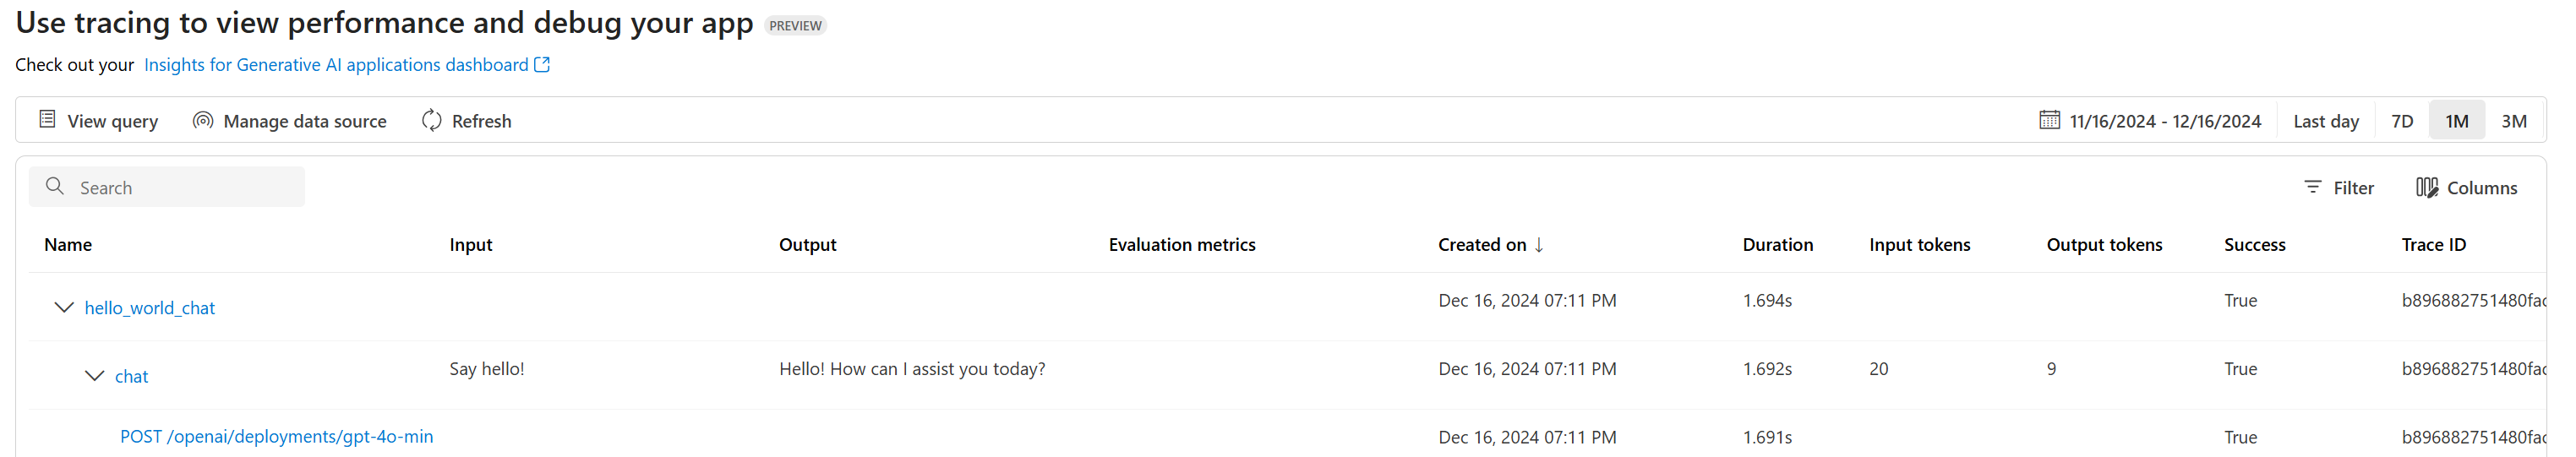
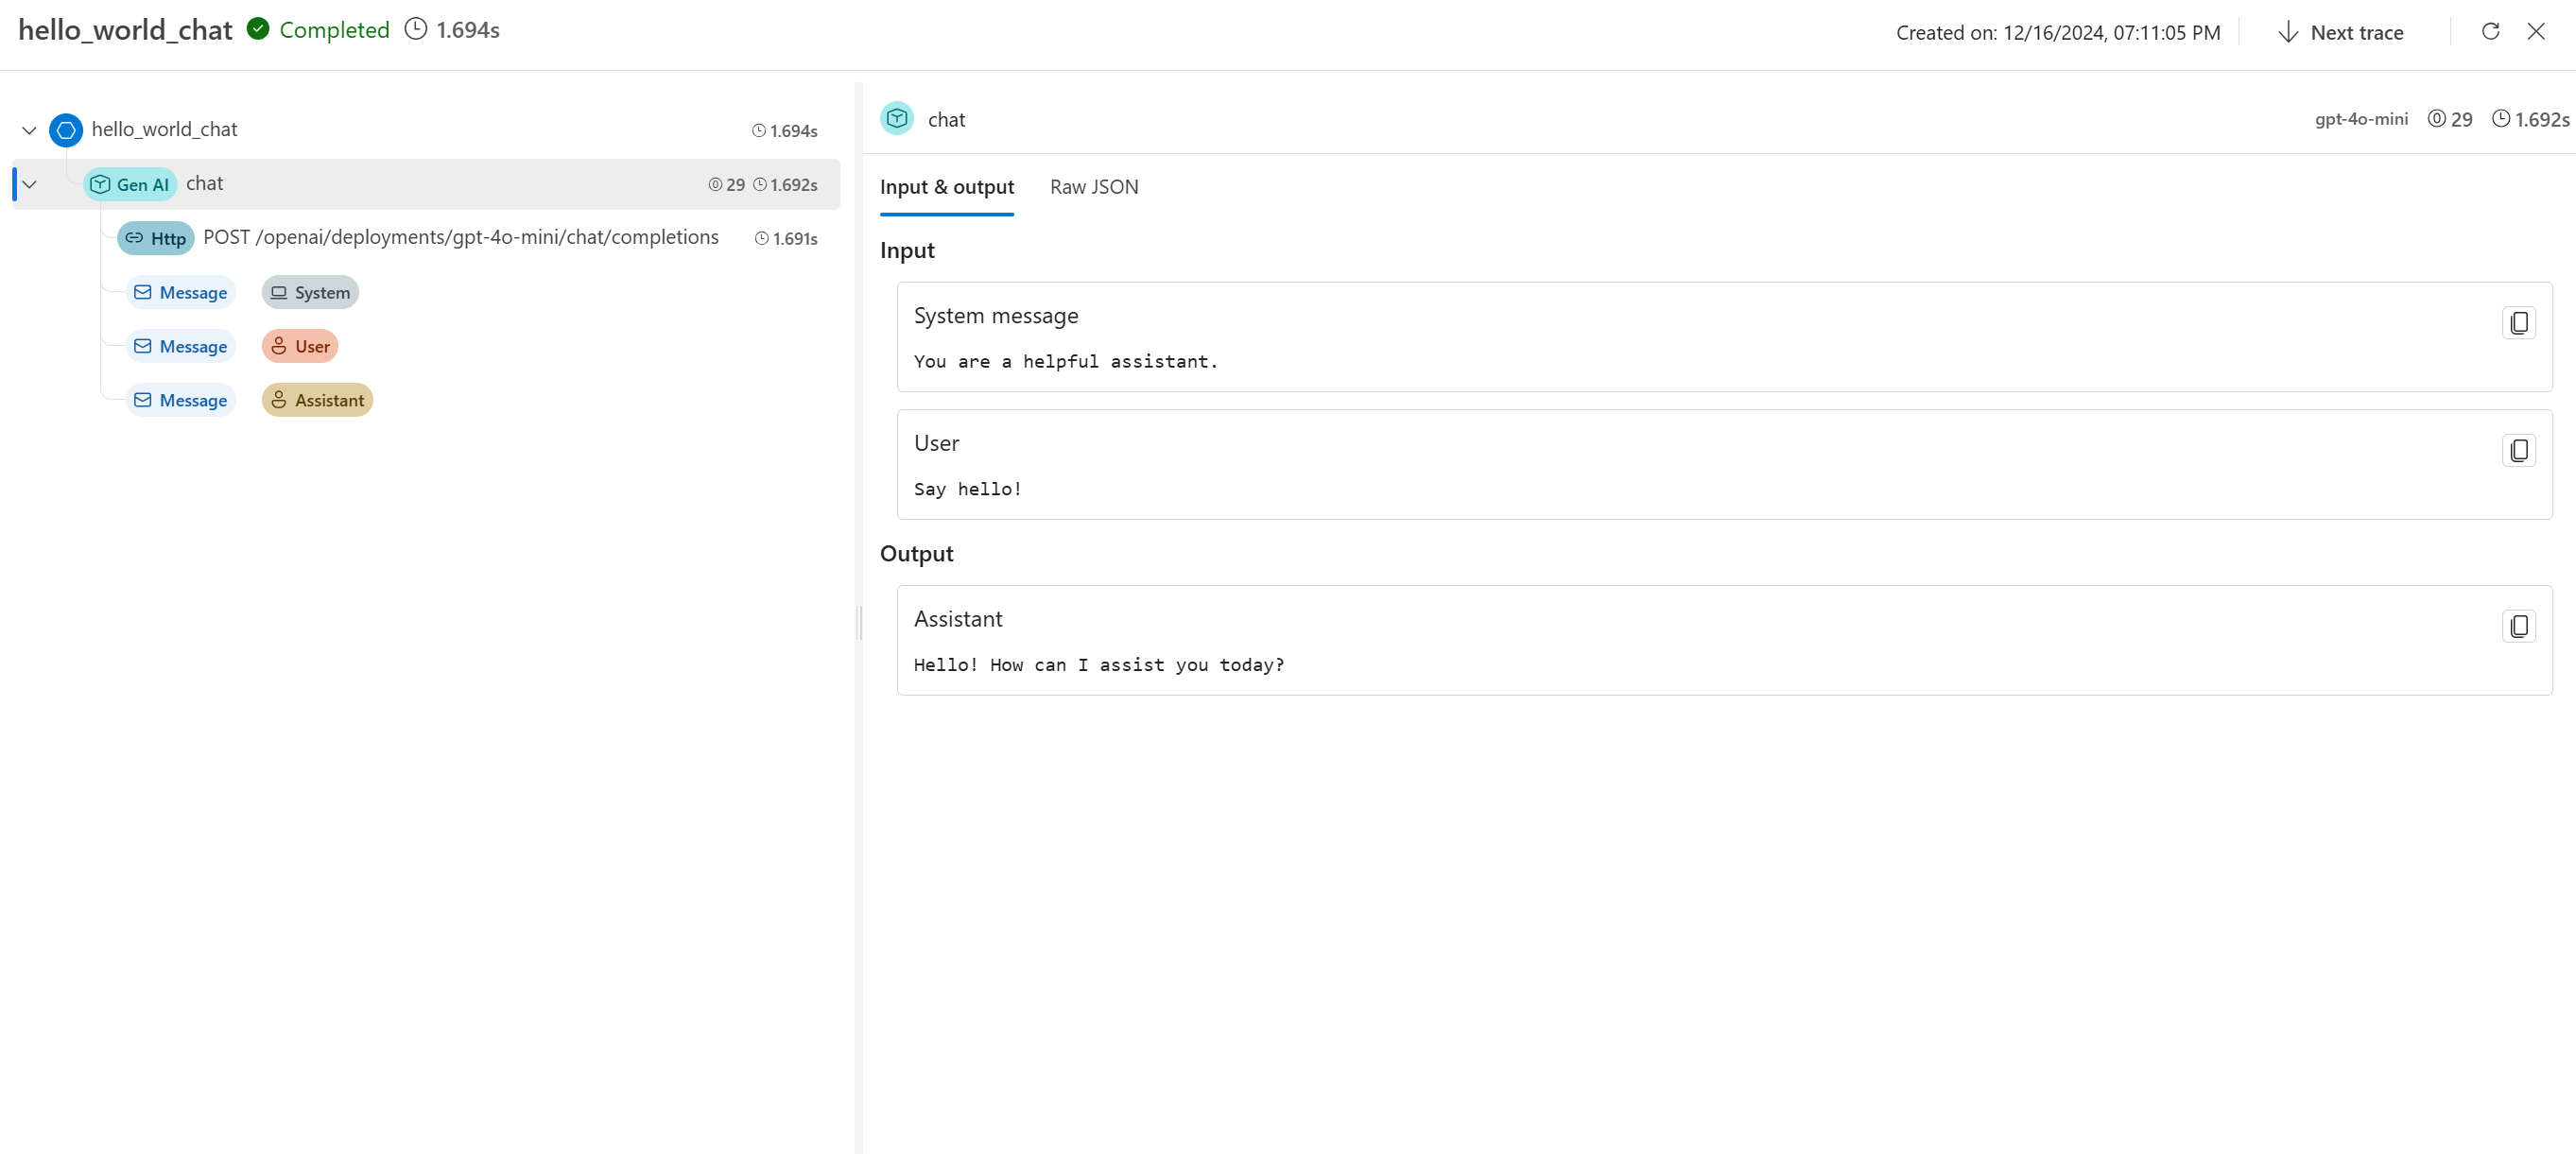